In [1]:
### Simulation of an arrival process with arrival rate lambda(t), 0<t<T
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, multivariate_normal, norm
import seaborn

## unconditional samples

In [2]:
import numpy as np

def is_positive_semidefinite(matrix):
    # Eigenvalue method
    eigenvalues = np.linalg.eigvals(matrix)
    if np.all(eigenvalues >= -1e-10):  # Allowing a small numerical tolerance
        eigenvalue_method = True
    else:
        eigenvalue_method = False

    # Cholesky decomposition method
    try:
        np.linalg.cholesky(matrix)
        cholesky_method = True
    except np.linalg.LinAlgError:
        cholesky_method = False

    return eigenvalue_method, cholesky_method

In [ ]:
#################### create a positive semidefinite matrix with diagnol being ones #####################
dim = 20
# Step 1: Create a random matrix
A = np.random.rand(dim, dim)*2-1

# Step 2: Make the matrix symmetric
A = 0.5 * (A + A.T)

# Step 3: Ensure positive semi-definiteness
cov_matrix = np.dot(A, A.T)

# Check the shape
print("Shape of the covariance matrix:", cov_matrix.shape)

std_dev = np.sqrt(np.diag(cov_matrix))

Shape of the covariance matrix: (20, 20)


In [4]:
std_dev.shape

(20,)

In [5]:
size = 100000

# total_dimension = 6


mu = np.array([0]*dim)
sigma = np.around(cov_matrix / np.outer(std_dev, std_dev), 2)
pareto_params = np.random.choice([6,7,8,9,10], dim)



def pareto_minus_1_cdf(x, a):
    return 1-(x+1)**(-a)

def inverse_pareto_minus_1_cdf(x, a):
    return (1-x)**(-1/a)-1


# Vectorize the function
pareto_minus_1_cdf_vectorized = np.vectorize(pareto_minus_1_cdf)
inverse_pareto_minus_1_cdf_vectorized = np.vectorize(inverse_pareto_minus_1_cdf)

In [6]:
pareto_params

array([ 7,  6,  6,  8,  9, 10,  9,  9,  6, 10, 10,  9,  8, 10, 10,  9,  7,
       10,  9,  7])

In [7]:
is_positive_semidefinite(sigma)

(True, True)

In [8]:
unconditional_normal_sample = np.random.multivariate_normal(mu, sigma, size = size)
unconditional_uniform_sample = norm.cdf(unconditional_normal_sample, loc=0, scale=1)
unconditional_pareto_sample = inverse_pareto_minus_1_cdf_vectorized(unconditional_uniform_sample, np.array(pareto_params))

(array([9.0715e+04, 7.7540e+03, 1.1550e+03, 2.5800e+02, 8.1000e+01,
        2.5000e+01, 7.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([5.19603555e-07, 4.05109516e-01, 8.10218512e-01, 1.21532751e+00,
        1.62043651e+00, 2.02554550e+00, 2.43065450e+00, 2.83576349e+00,
        3.24087249e+00, 3.64598149e+00, 4.05109048e+00]),
 <BarContainer object of 10 artists>)

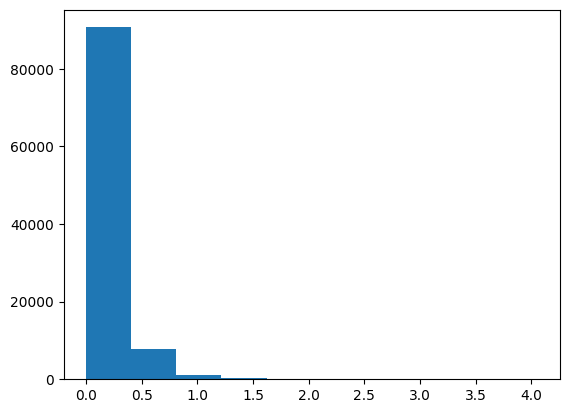

In [9]:
plt.hist(unconditional_pareto_sample[:,0])

In [10]:
## save data
unconditional_pareto_sample = unconditional_pareto_sample.reshape(size,2,-1)
print(unconditional_pareto_sample.shape)
np.save(f'pareto_{dim}d_data.npy', unconditional_pareto_sample)

(100000, 2, 10)


## conditional samples

In [11]:
size = 10000
condition_dimension = int(dim/2)
condition_value = np.mean(unconditional_pareto_sample,axis=(0))[0].round(2)+np.random.normal(0, 0.01, size = int(dim/2)).round(2)


In [12]:
condition_value_uniform = pareto_minus_1_cdf_vectorized(condition_value, pareto_params[:condition_dimension])
condition_value_normal = norm.ppf(condition_value_uniform)

In [13]:
mu_1 = mu[:condition_dimension]
mu_2 = mu[condition_dimension:]
sigma_11 = sigma[:condition_dimension,:condition_dimension]
sigma_12 = sigma[:condition_dimension,condition_dimension:]
sigma_21 = sigma[condition_dimension:,:condition_dimension]
sigma_22 = sigma[condition_dimension:,condition_dimension:]

conditional_mu = mu_2 + np.dot(np.dot(sigma_21, np.linalg.inv(sigma_11)), condition_value_normal-mu_1)
conditional_sigma = sigma_22 + np.dot(np.dot(sigma_21, np.linalg.inv(sigma_11)), sigma_12)

In [14]:
conditional_normal_sample = np.random.multivariate_normal(conditional_mu, conditional_sigma, size = size)
conditional_uniform_sample = norm.cdf(conditional_normal_sample, loc=0, scale=1)
conditional_pareto_sample = inverse_pareto_minus_1_cdf_vectorized(conditional_uniform_sample, np.array(pareto_params[condition_dimension:]))

# add the conditional dimensions at the beginning
conditional_pareto_sample = np.concatenate((np.tile(condition_value, (size, 1)),conditional_pareto_sample), axis = 1)

In [15]:
## save
conditional_pareto_sample = conditional_pareto_sample.reshape(size,2,-1)
print(conditional_pareto_sample.shape)
np.save(f'pareto_{dim}d_data_conditional.npy', conditional_pareto_sample)

(10000, 2, 10)
